# Preparación del entorno

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install numpy pandas scikit-learn torch transformers seaborn matplotlib tqdm accelerate

# Entrenamiento del modelo

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, TrainingArguments, Trainer
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import torch

In [4]:
if torch.cuda.is_available():
    print("CUDA está disponible. Dispositivos CUDA:", torch.cuda.device_count())
    print("Dispositivo CUDA por defecto:", torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print("CUDA no está disponible.")

CUDA está disponible. Dispositivos CUDA: 1
Dispositivo CUDA por defecto: Tesla V100-SXM2-16GB


In [7]:
class NewsDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        inputs = tokenizer(text, return_tensors='pt', max_length=512, truncation=True, padding='max_length')
        input_ids = inputs['input_ids'][0]
        attention_mask = inputs['attention_mask'][0]

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': torch.tensor(label)
        }

In [8]:
train_df = pd.read_csv('/content/drive/MyDrive/9categ/9cat_train_dataset.csv')
test_df = pd.read_csv('/content/drive/MyDrive/9categ/9cat_test_dataset.csv')

In [9]:
label2id = {label: id for id, label in enumerate(train_df['label'].unique())}
id2label = {id: label for label, id in label2id.items()}
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
train_dataset = NewsDataset(train_df['text'].tolist(), train_df['label'].map(label2id).tolist())
test_dataset = NewsDataset(test_df['text'].tolist(), test_df['label'].map(label2id).tolist())
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(label2id), label2id=label2id, id2label=id2label)
if torch.cuda.is_available():
    model.to('cuda')

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=10,
    per_device_train_batch_size=25,
    per_device_eval_batch_size=25,
    warmup_steps=300,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=200,
    evaluation_strategy="steps",
    eval_steps=100,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    greater_is_better=True,
    do_train=True,
    do_eval=True,
    do_predict=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=lambda p: {'accuracy': accuracy_score(p.label_ids, p.predictions.argmax(-1))}
)

trainer.train()

Step,Training Loss,Validation Loss,Accuracy
100,No log,1.500111,0.701111
200,1.500200,0.696157,0.785000
300,1.500200,0.499619,0.852778
400,0.583400,0.469049,0.861111
500,0.583400,0.440203,0.862222
600,0.481600,0.417982,0.877222
700,0.481600,0.343118,0.900000
800,0.323000,0.345569,0.901111
900,0.323000,0.330070,0.903889
1000,0.320000,0.318360,0.906667


TrainOutput(global_step=6120, training_loss=0.16009459100127998, metrics={'train_runtime': 5031.3664, 'train_samples_per_second': 30.409, 'train_steps_per_second': 1.216, 'total_flos': 2.0270042090496e+16, 'train_loss': 0.16009459100127998, 'epoch': 10.0})

In [11]:
folder_name = '/content/drive/MyDrive/9categ/9cat_distilbert_trained'
model.save_pretrained(folder_name)
tokenizer.save_pretrained(folder_name)

('/content/drive/MyDrive/9categ/9cat_distilbert_trained/tokenizer_config.json',
 '/content/drive/MyDrive/9categ/9cat_distilbert_trained/special_tokens_map.json',
 '/content/drive/MyDrive/9categ/9cat_distilbert_trained/vocab.txt',
 '/content/drive/MyDrive/9categ/9cat_distilbert_trained/added_tokens.json')

# Evaluación y predicciones

In [12]:
predictions = trainer.predict(test_dataset)

In [13]:
predicted_labels = [id2label[id] for id in predictions.predictions.argmax(-1)]
test_df['encoded_label'] = test_df['label'].map(label2id)
test_df['predicted_label'] = predicted_labels
test_df['encoded_predicted_label'] = test_df['predicted_label'].map(label2id)

In [14]:
test_df.to_csv('/content/drive/MyDrive/9categ/9cat_results_dataset_predictions_distilbert_finetuned.csv', index=False)

In [15]:
accuracy = accuracy_score(test_df['encoded_label'], test_df['encoded_predicted_label'])
precision, recall, f1, _ = precision_recall_fscore_support(test_df['encoded_label'], test_df['encoded_predicted_label'], average='weighted')
conf_matrix = confusion_matrix(test_df['encoded_label'], test_df['encoded_predicted_label'])

In [16]:
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.9477777777777778
Precision: 0.9486726542337375
Recall: 0.9477777777777778
F1 Score: 0.9479826812662205


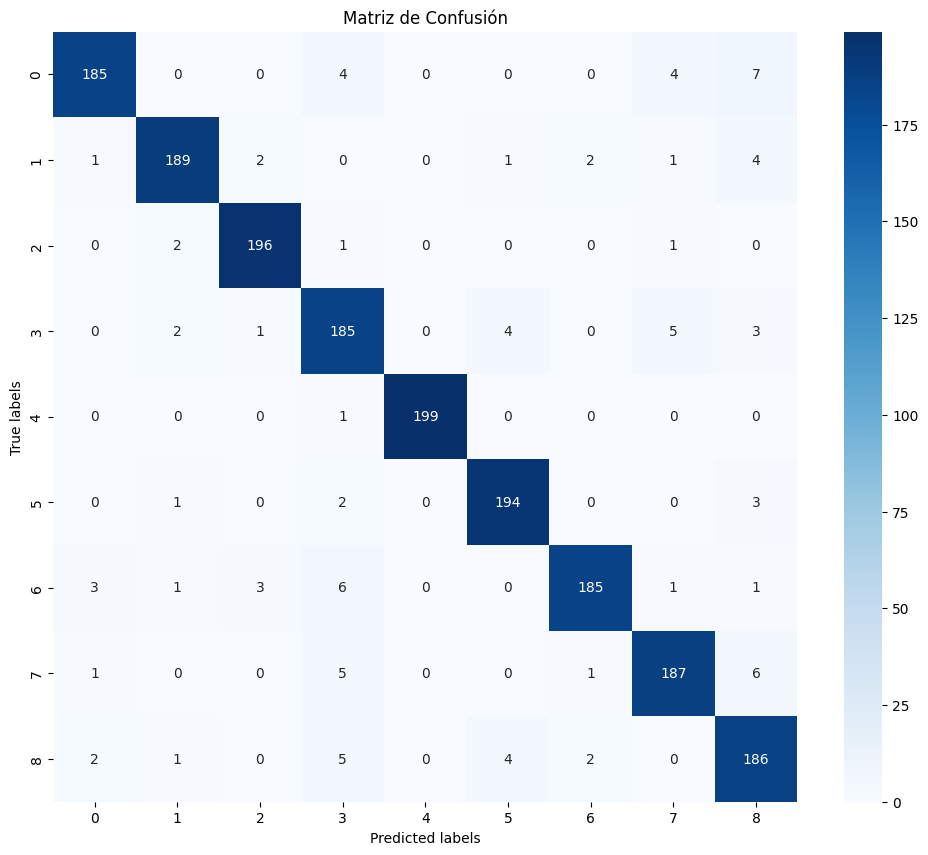

In [18]:
plt.figure(figsize=(12, 10))
cm = confusion_matrix(test_df["label"], test_df['predicted_label'])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Matriz de Confusión")
plt.show()